# <center> <font color='darkred'>An Example of Geostatistical Data Analysis</font></center>

* In this notebook, you will find an example of geostatistical data analysis. Initially, about a hundred measurements of a quantity (**T**) which is distributed over a region with horizontal distance (**X**) and vertical distance (**Y**) is taken. The aim of the study is to estimate the T values for all over the region.

## 1. Preparation & Descriptive Statistics of the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.optimize import curve_fit
from scipy.linalg import solve
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv("data_T.csv")

In [4]:
df.head()

,X,Y,LOGT,T,LNT
0,8.535,33.558,3.9042,8020,8.9898
1,6.858,32.194,4.1052,12741,9.4526
2,6.878,31.720,3.9804,9559,9.1652
3,7.372,31.700,4.0346,10829,9.2900
4,7.490,31.700,4.0946,12434,9.4282


In [5]:
x    = df["X"]
y    = df["Y"]
t    = df["T"].to_numpy()
logt = df["LOGT"].to_numpy()

In [6]:
df.describe()

,X,Y,LOGT,T,LNT
count,106.000000,106.000000,106.000000,106.000000,106.000000
mean,10.406179,24.323019,4.051443,15657.481132,9.328792
std,2.907868,5.817324,0.364857,12850.139338,0.840113
min,5.336000,8.656000,3.262800,1831.000000,7.512900
25%,7.905000,20.652000,3.762000,5781.500000,8.662350
50%,10.405000,25.257000,4.070600,11765.000000,9.372900
75%,12.401500,28.854000,4.349250,22358.000000,10.014500
max,16.996000,33.558000,4.825000,66834.000000,11.110000


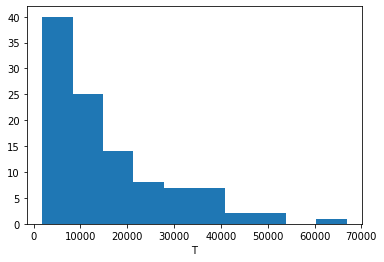

In [22]:
# Histogram of the data
plt.hist(t)
plt.xlabel("T")
plt.show()

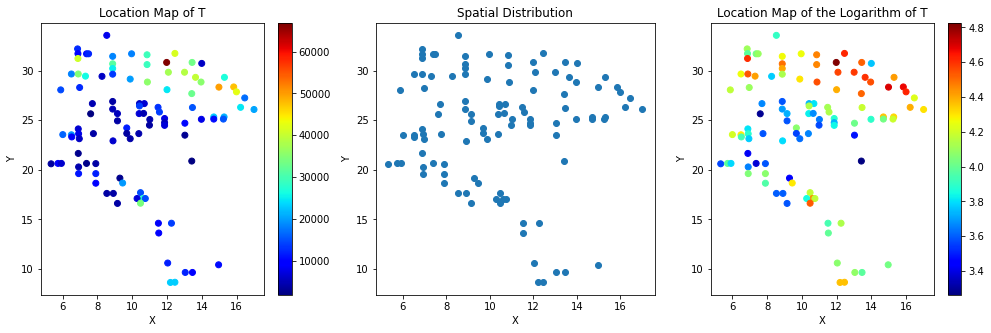

In [8]:
# Location Maps
plt.figure(figsize=(17,5))

# Location Map of T
plt.subplot(1,3,1)
plt.scatter(x, y, c = t, cmap = 'jet')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Location Map of T')
plt.colorbar()

# Spatial Distribution
plt.subplot(1,3,2)
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution')

# Location Map of the Logarithm of T
plt.subplot(1,3,3)
plt.scatter(x, y, c = logt, cmap = 'jet')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Location Map of the Logarithm of T')
plt.colorbar()

plt.show()


## 2. Variography

* Variography is the method used in order to determine the spatial correlation of the data. The semivariogram($\gamma$) function is
\begin{equation}
    \gamma(h) =\frac{1}{2N}\sum_{i,j}^N\left(T_i-T_j\right)^2
\end{equation}
where $h$ is the bin distance, $N$ is the number of measurements in corresponding bin, $T_i$ and $T_j$ is the T value of $i$'th and $j$'th values respectively. 

In [9]:
# Distance between measurements
H = []
for i in range(len(df)):
    for j in range(len(df)):
        dx = df.iloc[i,0]-df.iloc[j,0]
        dy = df.iloc[i,1]-df.iloc[j,1]
        h = (dx**2+dy**2)**(1/2)
        H.append(h)

In [10]:
# Lag distances
d = np.arange(0,20,0.25)

In [11]:
# Calculating variogram cloud
gamma = []
for i in range(len(df)):
    for j in range(len(df)):
        q = (1/2)*(df.iloc[i,2]-df.iloc[j,2])**2    
        gamma.append(q)

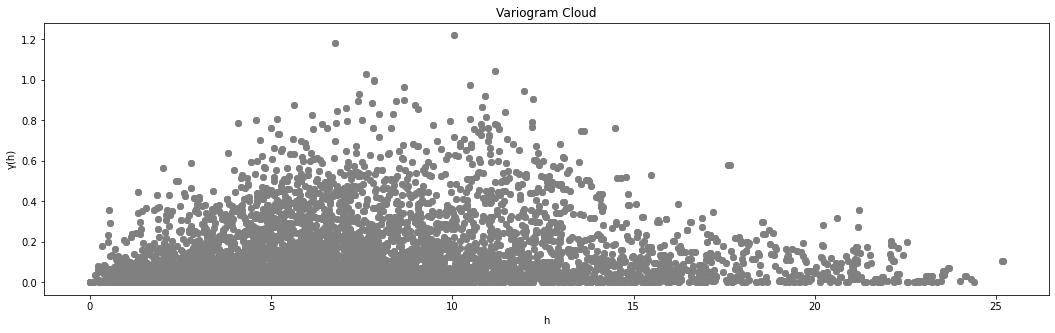

In [12]:
# Variogram cloud
plt.figure(figsize=(18,5))
plt.title('Variogram Cloud')
plt.scatter(H, gamma, color = 'grey')
plt.xlabel("h")
plt.ylabel("γ(h)")
plt.show()

* Some bins should be set in order to obtain experimental semivariogram.

In [13]:
# Calculating semivariogram with proper bins
var = []
temp = []
for k in range(len(H)):
    if H[k] == d[0]:
        temp.append(gamma[k])
q = sum(temp)/len(temp)
var.append(q)

        
for i in range(1,len(d)-1):
    temp = []
    for k in range(len(H)):
        if d[i] <= H[k] <= d[i+1]:
            temp.append(gamma[k])
    q = sum(temp)/len(temp)
    var.append(q)
temp = []
for k in range(len(H)):
    if H[k] > d[-1]:
        temp.append(gamma[k])
q = sum(temp)/len(temp)
var.append(q)



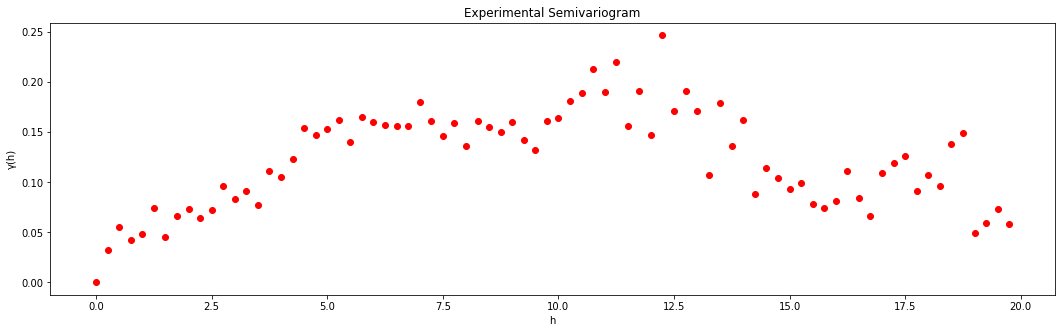

In [14]:
# Experimental Semivariogram
plt.figure(figsize=(18,5))
plt.title("Experimental Semivariogram")
plt.scatter(d,var, color ='red')
plt.xlabel("h")
plt.ylabel("γ(h)")
plt.show()

* After some distance is reached, some unreliable points are observed due to possible new characteristics of the region. The corrected experimental semivariogram is obtained by removing those unreliable points.

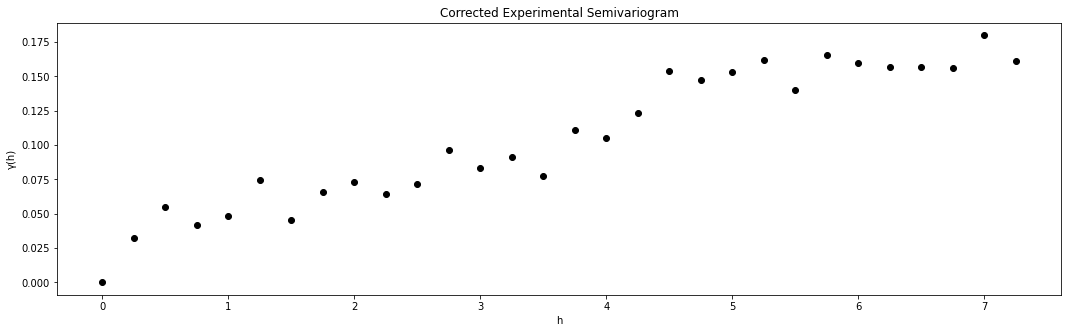

In [15]:
# Semivariogram with proper bins and points
d = d[0:30]
var = var[0:30]

plt.figure(figsize=(18,5))
plt.title("Corrected Experimental Semivariogram")
plt.scatter(d,var, color ='black')
plt.xlabel("h")
plt.ylabel("γ(h)")
plt.show()

sill: [0.15908726]
Gaussian Model:
R²: 0.9063283529324945
a: 17.431863522015174 b: 0.24209748324475122
------------------
Spherical Model
R²: 0.9022602126512054
a: 7.42334525874613 c: 0.16708029715567396
nugget:  0.03255768916666668
range:  4.5


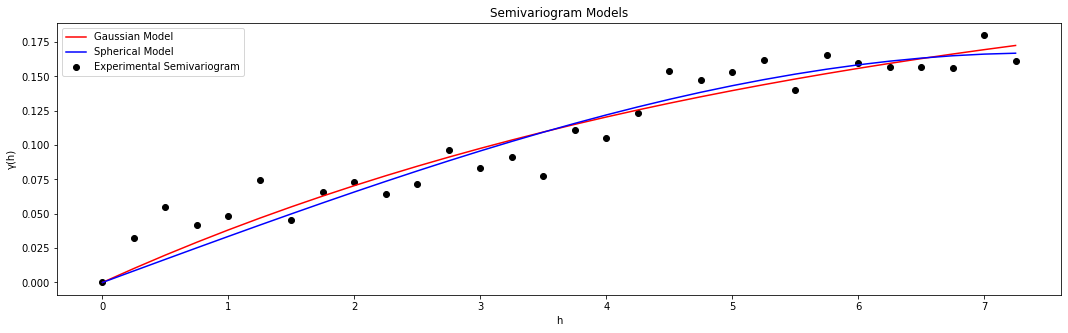

In [16]:
# Gaussian Model    
def gaus_var(x,a,b):
    return b*(1-np.exp((-3*x/a)))
def sill(x,y):
    return y

# Fit parameters
popt, pcov = curve_fit(gaus_var, d, var)      
sill0, sill1 = curve_fit(sill,d[20:29], var[20:29])
print("sill:", sill0)

# R² of the fit function
print("Gaussian Model:")
print("R²:",
      r2_score(var,gaus_var(d, *popt)))

# Plot of the fitted function
plt.figure(figsize=(18,5))
plt.title('Semivariogram Models')
plt.plot(d, gaus_var(d, *popt), label ='Gaussian Model', color = "red")
plt.scatter(d,var, label='Experimental Semivariogram', color='black')
plt.legend()

a,b = popt[0], popt[1]

print("a:", a,
     "b:", b)
print("------------------")
print("Spherical Model")
# Spherical Model    
def sph_var(x,a,c):
    for i in range(len(x)):
        if x[i] <= a:
            return c*(1.5*(x/a)-0.5*(x/a)**3)
        else:
            return c

# Fit parameters
popt, pcov = curve_fit(sph_var, d, var)      

# R² of the fit function
print("R²:",
      r2_score(var,sph_var(d, *popt)))
a,c = popt[0], popt[1]

print("a:", a,
     "c:", c)

print("nugget: ", var[1])
print("range: ",  d[18])

# Plot of the fitted function
plt.plot(d, sph_var(d, *popt), label ='Spherical Model', color="blue")
plt.legend()
plt.xlabel("h")
plt.ylabel("γ(h)")
plt.show()

$$ \gamma(h) = 0.24 \left(1-e^{-5.81h}\right) $$

In [17]:
# variogram matrix A
A = np.zeros((len(df)+1,len(df)+1))
for i in range(len(df)):
    for j in range(len(df)):            
        dx = df.iloc[i,0]-df.iloc[j,0]
        dy = df.iloc[i,1]-df.iloc[j,1]
        h = (dx**2+dy**2)**(1/2)
        A[i][j] = gaus_var(h,a,b)

# Adjusting n'th row and column as it is required
for k in range(len(A)):
    A[-1][k]=1
    A[k][-1]=1  

A[-1][-1] = 0

## 3. Estimating by Ordinary Kriging Method

* Kriging method basically assumes that all points are linearly dependent to each other with some weights.
\begin{equation}
    T^* = \sum_i^N w_iT_i
\end{equation}
* For a point $a$ taken from the dataset, the variogram relation for a point $p$ which will be estimated:
\begin{equation}
    \sum_i^N \gamma(a,i)w_i = \gamma(a,p)
\end{equation}
* In order to obtain unbiasedness all weights should sum up to 1.
\begin{equation}
    \sum_i^N w_i = 1
\end{equation}

In [18]:
# Coordinates of the region
predict = np.array(np.meshgrid(
        np.arange(6,17,.1),
        np.arange(8,34,.1)
        )).T.reshape(-1,2)

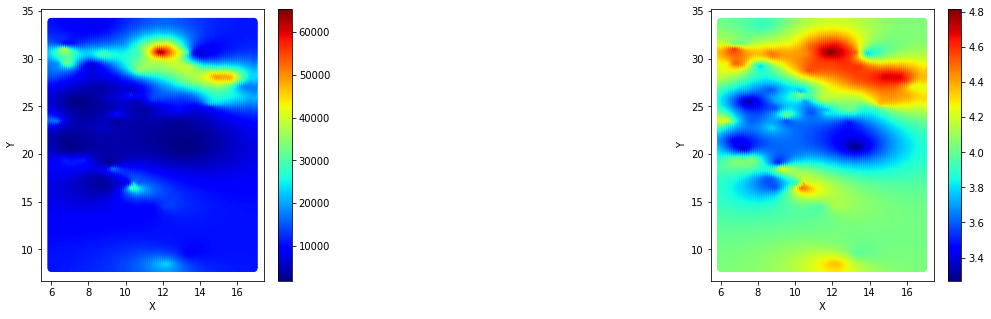

In [19]:
# solution of W
lagrangeMultiplier = []
prediction_logT = []
varPred = []
for new in range(len(predict)):
    B = []
    for i in range(len(df)):
        dx =  predict[new,0]-df.iloc[i,0]
        dy = predict[new,1]-df.iloc[i,1]
        h = (dx**2+dy**2)**(1/2)
        g = gaus_var(h,a,b)
        B.append(g)
    B.append(1)
    # solving the system of linear equations

    w = solve(A,B)
    temp =  []
    temp2 = []
    for element in range(len(w)-1):
        q3 = w[element]*df.iloc[element,2]
        temp.append(q3)
        q4 = w[element]*B[element]+ w[-1]
        temp2.append(q4)
    prediction_logT.append(sum(temp))
    varPred.append(sum(temp2))
    lagrangeMultiplier.append(w[-1])

    
plt.figure(figsize=(17,5))
plt.subplot(1,3,3)
plt.scatter(predict[:,0],
            predict[:,1], 
            c = prediction_logT,
            cmap = 'jet')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
prediction_T=[]
for i in range(
    len(prediction_logT)):
    prediction_T.append(10**prediction_logT[i])


plt.subplot(1,3,1)
plt.scatter(predict[:,0],
            predict[:,1], 
            c = prediction_T,
            cmap = 'jet')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## 4. Variance Calculation

* In order to determine the variance of the estimation Lagrange multiplier ($\lambda $) can be used. The variance equation for the point $p$ estimated is
 \begin{equation}
     \sigma_p^2 = \lambda + \sum_i^N w_i\gamma(i,p)
 \end{equation}

In [20]:
weig = [1/i for i in varPred]
weightedVar = sum(weig)**(-1)
print("Weighted 𝜎2 of the Model: ", weightedVar)

Weighted 𝜎2 of the Model:  4.3519192750318895e-06


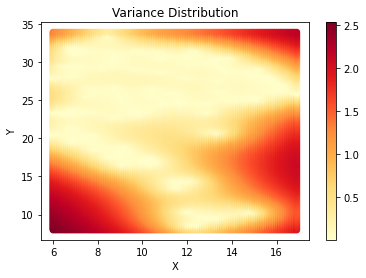

In [21]:
plt.scatter(predict[:,0],
            predict[:,1], 
            c = varPred,
            cmap = 'YlOrRd')
plt.title("Variance Distribution")
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## 5. Conclusion

* The  results obtained are consistent with the initial data taking into account the variance of  each  element. 
* One  key  point  to  be  aware  of  is  that  the  initial  data  does not  cover  the  entire  region.  There  are  no  sufficient  number  of  measurements at the bottom corners of the map.  This means that the results at those points are highly unreliable since there may be other characteristics at those locations. It is supported by the fact that high variances are observed in those locations